PPP (with BM3D) CT Reconstruction (ADMM with Fast SVMBIR Prox)
==============================================================

This example demonstrates solution of a tomographic reconstruction
problem using the Plug-and-Play Priors framework
<cite data-cite="venkatakrishnan-2013-plugandplay2"/>, using BM3D
<cite data-cite="dabov-2008-image"/> as a denoiser and SVMBIR <cite data-cite="svmbir-2020"/> for
tomographic projection.

There are two versions of this example, solving the same problem in two
different ways. This version uses the data fidelity term as one of the
ADMM $g$ functionals so that the optimization with respect to the data
fidelity is able to exploit the internal prox of the `SVMBIRExtendedLoss`
and `SVMBIRSquaredL2Loss` functionals. The
[other version](ct_svmbir_ppp_bm3d_admm_cg.rst) solves the ADMM subproblem
corresponding to the data fidelity term via CG.

Two ways of exploiting the SVMBIR internal prox are explored in this
example:
1. Using the `SVMBIRSquaredL2Loss` together with the BM3D pseudo-functional
   and a non-negative indicator function, and
2. Using the `SVMBIRExtendedLoss`, which includes a non-negativity
   constraint, together with the BM3D pseudo-functional.

In [1]:
import numpy as np

import matplotlib.pyplot as plt
import svmbir
from matplotlib.ticker import MaxNLocator
from xdesign import Foam, discrete_phantom

import scico.numpy as snp
from scico import metric, plot
from scico.functional import BM3D, NonNegativeIndicator
from scico.linop import Diagonal, Identity
from scico.linop.xray.svmbir import (
    SVMBIRExtendedLoss,
    SVMBIRSquaredL2Loss,
    XRayTransform,
)
from scico.optimize.admm import ADMM, LinearSubproblemSolver
from scico.util import device_info
plot.config_notebook_plotting()

Generate a ground truth image.

In [2]:
N = 256  # image size
density = 0.025  # attenuation density of the image
np.random.seed(1234)
x_gt = discrete_phantom(Foam(size_range=[0.075, 0.005], gap=2e-3, porosity=1.0), size=N - 10)
x_gt = x_gt / np.max(x_gt) * density
x_gt = np.pad(x_gt, 5)
x_gt[x_gt < 0] = 0

Generate tomographic projector and sinogram.

In [3]:
num_angles = int(N / 2)
num_channels = N
angles = snp.linspace(0, snp.pi, num_angles, endpoint=False, dtype=snp.float32)
A = XRayTransform(x_gt.shape, angles, num_channels)
sino = A @ x_gt

Impose Poisson noise on sinogram. Higher max_intensity means less noise.

In [4]:
max_intensity = 2000
expected_counts = max_intensity * np.exp(-sino)
noisy_counts = np.random.poisson(expected_counts).astype(np.float32)
noisy_counts[noisy_counts == 0] = 1  # deal with 0s
y = -np.log(noisy_counts / max_intensity)

Reconstruct using default prior of SVMBIR <cite data-cite="svmbir-2020"/>.

In [5]:
weights = svmbir.calc_weights(y, weight_type="transmission")

x_mrf = svmbir.recon(
    np.array(y[:, np.newaxis]),
    np.array(angles),
    weights=weights[:, np.newaxis],
    num_rows=N,
    num_cols=N,
    positivity=True,
    verbose=0,
)[0]

Convert numpy arrays to jax arrays.

In [6]:
y = snp.array(y)
x0 = snp.array(x_mrf)
weights = snp.array(weights)

Set problem parameters and BM3D pseudo-functional.

In [7]:
ρ = 10  # ADMM penalty parameter
σ = density * 0.26  # denoiser sigma
g0 = σ * ρ * BM3D()

Set up problem using `SVMBIRSquaredL2Loss` and `NonNegativeIndicator`.

In [8]:
f_l2loss = SVMBIRSquaredL2Loss(
    y=y, A=A, W=Diagonal(weights), scale=0.5, prox_kwargs={"maxiter": 5, "ctol": 0.0}
)
g1 = NonNegativeIndicator()

solver_l2loss = ADMM(
    f=None,
    g_list=[f_l2loss, g0, g1],
    C_list=[Identity(x_mrf.shape), Identity(x_mrf.shape), Identity(x_mrf.shape)],
    rho_list=[ρ, ρ, ρ],
    x0=x0,
    maxiter=20,
    subproblem_solver=LinearSubproblemSolver(cg_kwargs={"tol": 1e-3, "maxiter": 100}),
    itstat_options={"display": True, "period": 5},
)

Run the ADMM solver.

In [9]:
print(f"Solving on {device_info()}\n")
x_l2loss = solver_l2loss.solve()
hist_l2loss = solver_l2loss.itstat_object.history(transpose=True)

Solving on GPU (NVIDIA GeForce RTX 2080 Ti)



Iter  Time      Prml Rsdl  Dual Rsdl  CG It  CG Res   
------------------------------------------------------
   0  3.10e+00  2.032e+00  4.609e+00      0  3.760e-08


   5  2.03e+01  5.631e-01  1.998e+00      1  1.807e-09


  10  4.07e+01  2.648e-01  7.427e-01      1  9.401e-10


  15  6.05e+01  1.708e-01  4.365e-01      1  5.628e-10


  19  7.63e+01  1.409e-01  3.574e-01      1  5.773e-10


Set up problem using `SVMBIRExtendedLoss`, without need for `NonNegativeIndicator`.

In [10]:
f_extloss = SVMBIRExtendedLoss(
    y=y,
    A=A,
    W=Diagonal(weights),
    scale=0.5,
    positivity=True,
    prox_kwargs={"maxiter": 5, "ctol": 0.0},
)

solver_extloss = ADMM(
    f=None,
    g_list=[f_extloss, g0],
    C_list=[Identity(x_mrf.shape), Identity(x_mrf.shape)],
    rho_list=[ρ, ρ],
    x0=x0,
    maxiter=20,
    subproblem_solver=LinearSubproblemSolver(cg_kwargs={"tol": 1e-3, "maxiter": 100}),
    itstat_options={"display": True, "period": 5},
)

Run the ADMM solver.

In [11]:
print()
x_extloss = solver_extloss.solve()
hist_extloss = solver_extloss.itstat_object.history(transpose=True)

Iter  Time      Prml Rsdl  Dual Rsdl  CG It  CG Res   
------------------------------------------------------
   0  3.63e+00  1.815e+00  3.736e+00      0  0.000e+00


   5  2.37e+01  3.681e-01  8.979e-01      1  3.080e-09


  10  4.29e+01  1.707e-01  3.860e-01      1  1.025e-09


  15  6.25e+01  1.287e-01  2.944e-01      1  8.576e-10


  19  7.83e+01  1.154e-01  2.775e-01      1  1.229e-10


Show the recovered images.

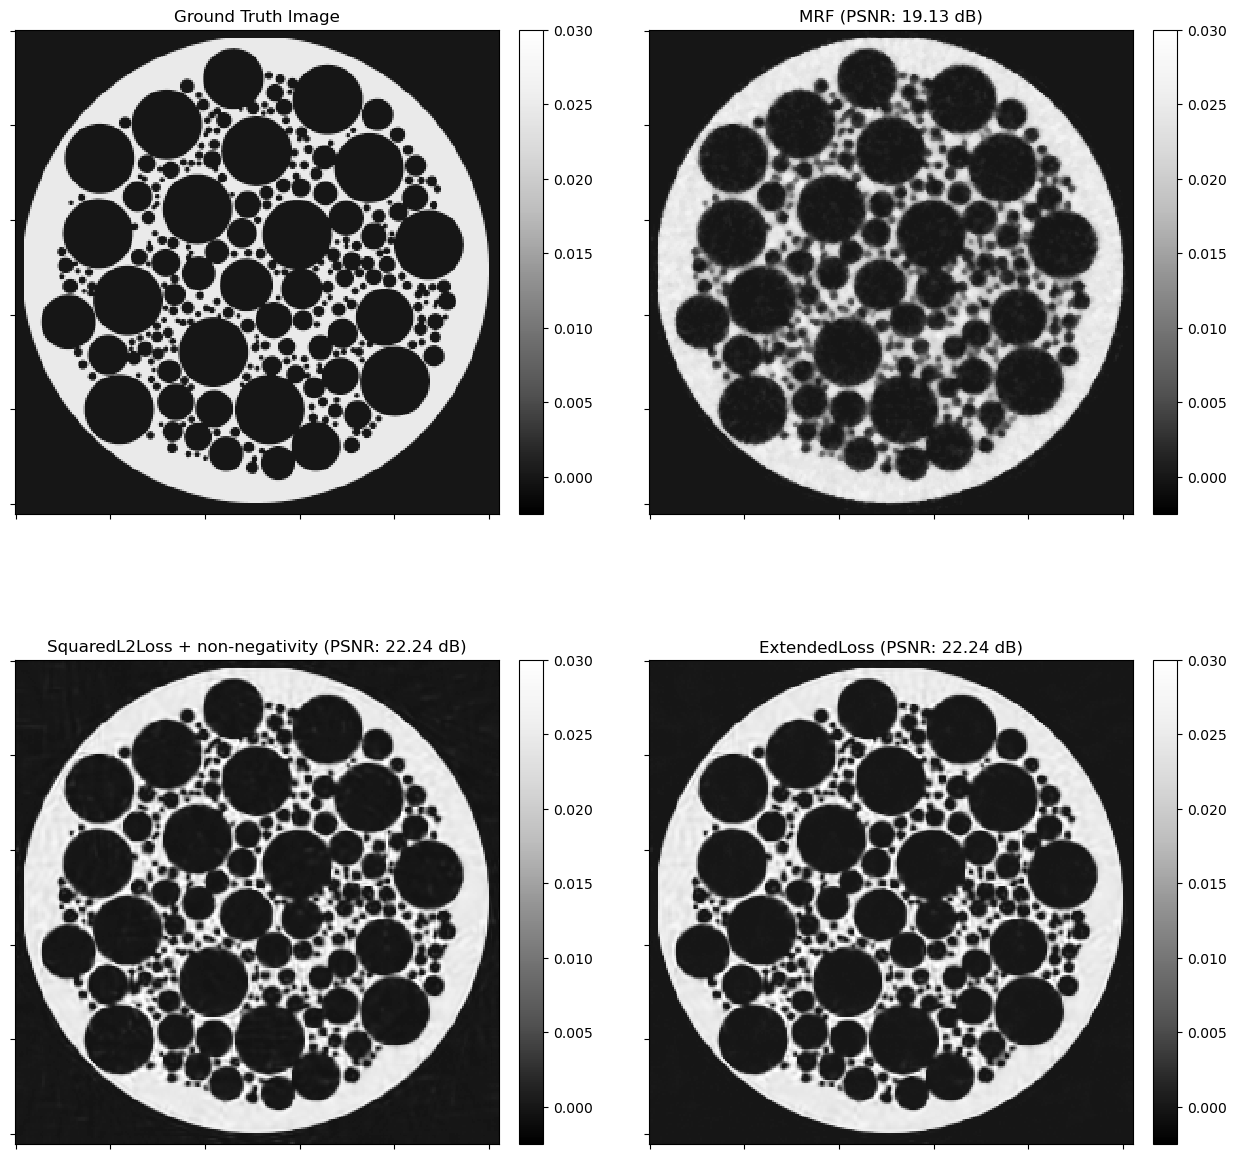

In [12]:
norm = plot.matplotlib.colors.Normalize(vmin=-0.1 * density, vmax=1.2 * density)
fig, ax = plt.subplots(2, 2, figsize=(15, 15))
plot.imview(img=x_gt, title="Ground Truth Image", cbar=True, fig=fig, ax=ax[0, 0], norm=norm)
plot.imview(
    img=x_mrf,
    title=f"MRF (PSNR: {metric.psnr(x_gt, x_mrf):.2f} dB)",
    cbar=True,
    fig=fig,
    ax=ax[0, 1],
    norm=norm,
)
plot.imview(
    img=x_l2loss,
    title=f"SquaredL2Loss + non-negativity (PSNR: {metric.psnr(x_gt, x_l2loss):.2f} dB)",
    cbar=True,
    fig=fig,
    ax=ax[1, 0],
    norm=norm,
)
plot.imview(
    img=x_extloss,
    title=f"ExtendedLoss (PSNR: {metric.psnr(x_gt, x_extloss):.2f} dB)",
    cbar=True,
    fig=fig,
    ax=ax[1, 1],
    norm=norm,
)
fig.show()

Plot convergence statistics.

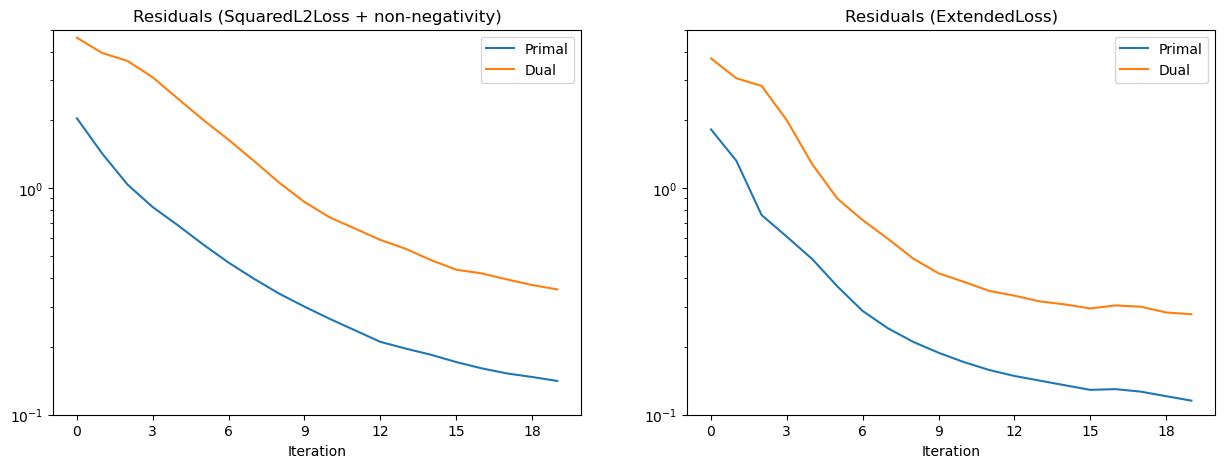

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
plot.plot(
    snp.vstack((hist_l2loss.Prml_Rsdl, hist_l2loss.Dual_Rsdl)).T,
    ptyp="semilogy",
    title="Residuals (SquaredL2Loss + non-negativity)",
    xlbl="Iteration",
    lgnd=("Primal", "Dual"),
    fig=fig,
    ax=ax[0],
)
ax[0].set_ylim([1e-1, 5e0])
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
plot.plot(
    snp.vstack((hist_extloss.Prml_Rsdl, hist_extloss.Dual_Rsdl)).T,
    ptyp="semilogy",
    title="Residuals (ExtendedLoss)",
    xlbl="Iteration",
    lgnd=("Primal", "Dual"),
    fig=fig,
    ax=ax[1],
)
ax[1].set_ylim([1e-1, 5e0])
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
fig.show()